In [4]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
import decode
import numpy as np
import importlib
importlib.reload(decode)

<module 'decode' from '/home/bagel/lasercutter/decode.py'>

In [5]:
filename = "box.rd"
with open(filename, "rb") as f:
    data = decode.unscramble(f.read())
cmds = decode.parse_msgs(decode.split_msg(data))
for i in cmds:
    print(i)

UploadFollows(cmd=CmdCode(code=[216, 18], length=2))
E732(cmd=CmdCode(code=[231, 50], length=2), x=AbsValue(value=352454423, length=5, signed=False), y=AbsValue(value=352454423, length=5, signed=False))
F0(cmd=CmdCode(code=[240], length=1))
Start2(cmd=CmdCode(code=[241, 2, 0], length=3))
LightRed(cmd=CmdCode(code=[216, 0], length=2))
Feedrate(cmd=CmdCode(code=[231, 6], length=2), x=AbsValue(value=0, length=5, signed=False), y=AbsValue(value=0, length=5, signed=False))
E738(cmd=CmdCode(code=[231, 56, 0], length=3))
Laser1TopLeft(cmd=CmdCode(code=[231, 3], length=2), x=AbsValue(value=0, length=5, signed=False), y=AbsValue(value=0, length=5, signed=False))
Laser1BottomRight(cmd=CmdCode(code=[231, 7], length=2), x=AbsValue(value=10000, length=5, signed=False), y=AbsValue(value=10000, length=5, signed=False))
Laser2TopLeft(cmd=CmdCode(code=[231, 80], length=2), x=AbsValue(value=0, length=5, signed=False), y=AbsValue(value=0, length=5, signed=False))
Laser2BottomRight(cmd=CmdCode(code=[231, 

In [19]:
layers = []
for x in range(5):
    for y in range(5):
        layers.append(decode.LayerData(
            color=(0, (x+1)/5.0, (y+1) / 5.0),
            layer=x * 5 + y,
            min_power=decode.scale_power((x + 1) * 20),
            max_power=decode.scale_power((x + 1) * 20),
            speed= (10 * (y + 1)) * 1000,
            x_min=0, y_min=0,
            x_max=0, y_max=0))


unpacked_msgs = decode.header(50000, 50000, layers)


for x in range(5):
    for y in range(5):
        unpacked_msgs += layers[x * 5 + y].change_header()
        
        unpacked_msgs += [
            decode.MoveAbs.from_values(x=int(0 + x * 10000), y=int(0 + y * 10000)),
            decode.CutAbs.from_values(x=int(6000 + x * 10000), y=int(0 + y * 10000)),
            decode.CutAbs.from_values(x=int(6000 + x * 10000), y=int(6000 + y * 10000)),
            decode.CutAbs.from_values(x=int(0 + x * 10000), y=int(6000 + y * 10000)),
            decode.CutAbs.from_values(x=int(0 + x * 10000), y=int(0 + y * 10000))]
unpacked_msgs += decode.footer(80,80)

In [16]:
repacked = []
    
for i in unpacked_msgs:
    if isinstance(i, decode.CmdMsg):
        repacked += i.pack()
        continue
    repacked += i

out_filename = "repacked.rd"
with open(out_filename, "wb") as f:
    f.write(bytearray(decode.scramble(repacked)))

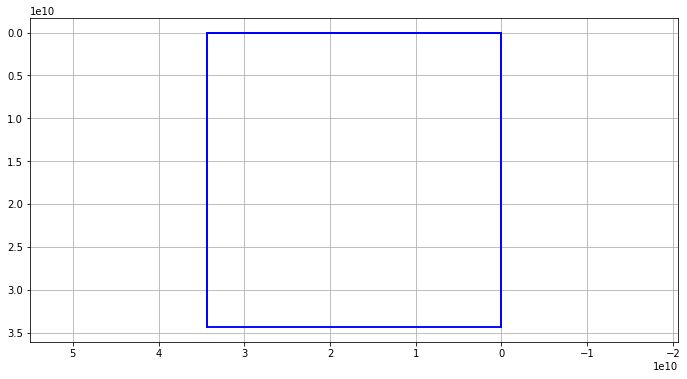

In [18]:
# Output file inspection

with open(out_filename, "rb") as f:
    data = decode.unscramble(f.read())
cmds = decode.parse_msgs(decode.split_msg(data))
laser_sim = decode.LaserSimulator()

for i in cmds:
    if isinstance(i, decode.CmdMsg):
        i.update(laser_sim)
laser_sim.show()
